In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=False
pseudo_label=False
# val_folder = 'sample_test_sync'
val_folder = 'val'
S_PREFIX = '36-resnet-softmax'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    if pad_right == 32: pad_right = 0
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.875)
    yc[cutoff_y:,:] = 0
    rn = ~(yr | yc)
    return torch.from_numpy(np.stack((rn,yc,yr)).astype(int))

def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [17]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [18]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
#     val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [19]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    x_np = x_np*std+mean
    return x_np

### Visualize data

In [ ]:
sz = 96
bs = 2
ext = '-150'
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

In [ ]:
x,y = md.val_ds[259]

In [ ]:
plt.imshow(y[1])

In [ ]:
y.shape

In [ ]:
plt.imshow(y[1])

In [ ]:
x_out = denorm(x)

In [ ]:
plt.imshow(x_out)

In [ ]:
plt.imshow(y)

## U-net (ish)

In [20]:
from torchvision.models import vgg11_bn

In [21]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [22]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [23]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [24]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [25]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [26]:
class Unet34(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [27]:
class Unet34Mod(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,16,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(3,16,1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [28]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [29]:
def car_f_p_r(pred, targs):
#     p2 = F.sigmoid(pred)
    _,idx = torch.max(pred, 1)
    p2 = idx
    return fbeta_score(p2==1, targs[:,1,:,:], beta=2)

In [30]:
def rd_f(pred, targs):
    _,idx = torch.max(pred, 1)
#     p2 = F.sigmoid(pred)
    p2 = idx
    f,p,r = fbeta_score(p2==2, targs[:,2,:,:], beta=0.5)
    return f

In [31]:
def fbeta_score(y_pred, y_true, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [32]:
def new_acc(pred, targs):
    _,idx = torch.max(pred, 1)
    _,t_idx = torch.max(targs,1)
#     idx = F.softmax(pred) > 0.5
    return (idx == t_idx).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [33]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, logits, targets):
        probs = F.softmax(logits)
        num = targets.size(0)  # Number of batches
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
            
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [34]:
def get_learner(md, m_fn=Unet34, half=False):
    m = to_gpu(m_fn())
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor([1,100,2])
    if half:
        class_weights = class_weights.half()
        learn.half()
#     learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit=SoftDiceLoss(weight=class_weights)
    learn.metrics=[new_acc, rd_f, car_f_p_r]
    return learn

### Settings

In [42]:
ext = '-150'
sz = 96
bs = 128
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [43]:
learn.load('600urn-19-weights-26-r8')

In [37]:
# learn.half()

In [44]:
learn.freeze_to(1)

In [ ]:
%pdb on

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.995006   0.999607   0.244105   0.252338   0.077713   0.017356   0.599604  


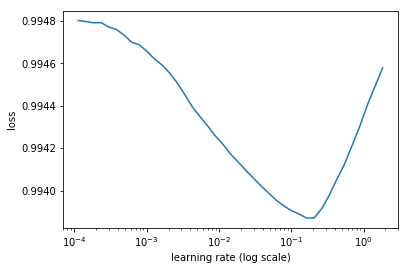

In [45]:
learn.lr_find()
learn.sched.plot()

In [46]:
lr=5e-2
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [47]:
learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993152   0.992783   0.882103   0.893724   0.475165   0.909205   0.425177  
    1      0.993022   0.994051   0.758943   0.592105   0.288871   0.948238   0.246406  
    2      0.99314    0.993635   0.828576   0.729006   0.306849   0.809812   0.265992  
    3      0.993203   0.992498   0.905472   0.912365   0.508657   0.872582   0.461214  
    4      0.993135   0.994548   0.828319   0.806907   0.104333   0.971724   0.085447  
    5      0.993127   0.994277   0.779167   0.64063    0.248899   0.756205   0.213214  
    6      0.993628   0.99969    0.066893   0.217358   0.075646   0.01638    0.798391  
    7      0.993704   0.999566   0.253174   0.194462   0.099736   0.021796   0.954138  
    8      0.993585   0.996127   0.693626   0.127586   0.024123   0.826743   0.019417  
    9      0.993604   0.9955     0.694754   0.533319   0.06509    0.906089   0.05286   
    10     0.994197   0.999505   0.287098   0.252532 

Process Process-205:
Process Process-206:
Process Process-210:
Process Process-208:
Process Process-209:
Process Process-207:
Traceback (most recent call last):
Process Process-204:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/pr

Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-e6f98a039510>", line 1, in <module>
    learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/learner.py", line 287, in fit
    return self.fit_gen(self.model, self.data, layer_opt, n_cycle, **kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/learner.py", line 234, in fit_gen
    swa_eval_freq=swa_eval_freq, **kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/model.py", line 132, in fit
    loss = model_stepper.step(V(x),V(y), epoch)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/model.py", line 54, in step
    loss = raw_loss = self.crit(output,

  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 52, in pil_loader
    return img.convert('RGB')
  File "<ipython-input-9-e4a515af82db>", line 25, in __getitem__
    x,y = self.get_x(idx),self.get_y(idx)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/transforms/functional.py", line 32, in to_tensor
    def to_tensor(pic):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/PIL/Image.py", line 879, in convert
    self.load()
  File "<ipython-input-9-e4a515af82db>", line 13, in get_x
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 579, in __call__
    return transform(img)
KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 52, in pil_loader


KeyboardInterrupt: 

In [ ]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

In [ ]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=10,use_clr=(20,10))

In [ ]:
learn.save(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:10])))

In [ ]:
# py = np.argmax(py,1)

In [ ]:
show_img(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0.5);

In [ ]:
show_img(py[0][1]>0.5);

In [ ]:
show_img(y[0][1]);

## 256x256

In [ ]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

In [ ]:
lr=2e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [48]:
import gc
gc.collect()

10583

In [ ]:
learn = get_learner(md)

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

In [ ]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

In [ ]:
learn.fit(lrs/8,1,wds=wd, cycle_len=8,use_clr=(20,4))

In [ ]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
x,y = next(iter(md.trn_dl))

In [ ]:
x.shape

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:8])))

In [ ]:
plt.imshow(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[-1]);

### No Crop

In [ ]:
ext = '-300'
sz=192
bs=32
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

In [ ]:
learn = get_learner(md)

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lr=1e-3
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

In [ ]:
learn.save(f'256urn-{S_PREFIX}-nocrop')

## 512x512

In [ ]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
# learn.load(f'256urn-{S_PREFIX}')
learn.load(f'256urn-{S_PREFIX}-nocrop')

In [ ]:
learn.freeze_to(1)

In [ ]:
lr=1e-3
wd=5e-7

In [ ]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(10,4))

In [ ]:
learn.fit(lr/4,1, wds=wd, cycle_len=4,use_clr=(10,4))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs/40,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save(f'600urn-{S_PREFIX}')

In [ ]:
learn.sched.plot_loss()

### No Crop

In [35]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=6
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 30
Val x:30, y:30
Trn x:7280, y:7280
All x:7280


In [50]:
# learn.load(f'600urn-{S_PREFIX}')
# learn.load(f'256urn-{S_PREFIX}-nocrop')
learn.load('600urn-19-weights-26-r8')

In [51]:
lr=2e-3
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])/2

In [52]:
learn.unfreeze()
learn.bn_freeze(True)

In [53]:
learn.fit(lrs,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.918275   0.921457   0.966656   0.976684   0.845832   0.889769   0.838338  
    1      0.918005   0.919771   0.990204   0.993705   0.8594     0.8887     0.855686  
    2      0.91792    0.919523   0.991392   0.994501   0.858669   0.893447   0.853259  
    3      0.91784    0.919386   0.992648   0.994742   0.859241   0.898897   0.852854  


[array([0.91939]),
 0.9926476961374283,
 0.9947420688216911,
 0.8592405809137955,
 0.8988973181474376,
 0.8528539478902745]

In [54]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-nocrop-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/6,1, wds=wd,cycle_len=4,use_clr=(20,2))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp-2')

In [ ]:
learn.fit(lrs/50,1, wds=wd,cycle_len=4,use_clr=(20,2))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-nocrop')

### Visualize Results

In [36]:
learn.load(f'600urn-36-resnet-softmax-nocrop-tmp')

In [37]:
val_it = iter(md.val_dl)

In [38]:
x,y = next(val_it)

In [60]:
x[1].mean()

-0.0740935039341068

In [61]:
x.shape

torch.Size([6, 3, 384, 800])

In [40]:
type(x)

torch.FloatTensor

In [41]:
res = learn.model(V(x).cuda())

In [50]:
mx,idx = torch.max(res,1)
idx = idx.cpu().data.numpy()

In [56]:
idx.shape

(6, 384, 800)

In [51]:
type(idx)

numpy.ndarray

In [53]:
i=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


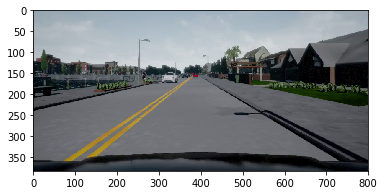

In [54]:
plt.imshow(denorm(x[i]))

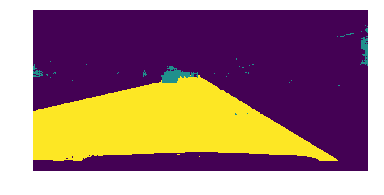

In [57]:
show_img(idx[i]);

In [63]:
idx[0].mean()

0.594267578125

In [ ]:
show_img(py[idx][1]);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[idx][0]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [ ]:
# model_summary(m, [3,608,800])

In [ ]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [ ]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()